In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# STEP 1:  Generate the dataset
Helper Function to create the data

In [2]:
def makeDataQuadratic(myseed,quantity=100,myscale=0.0):
    np.random.seed(myseed)   #dont forget to import numpy as np
    x = np.random.uniform(low=-1.,high=1.,size=quantity)  
    y = 2 * (x ** 2)+np.random.normal(size = quantity,scale = myscale)
    mean_y = np.mean(y)
    ydebiased = y-mean_y  #debias the data by subtracting the mean of y
    df = pd.DataFrame({'x':x, 'y':ydebiased}) #dont forget to import pandas as pd
    return(df) 

Generate the quadratic dataset

In [3]:
myseed = 1

df = makeDataQuadratic(myseed,quantity=200,myscale=0.5)

Scatterplot the dataset

Text(0.5, 1.0, 'X vs. Y for df')

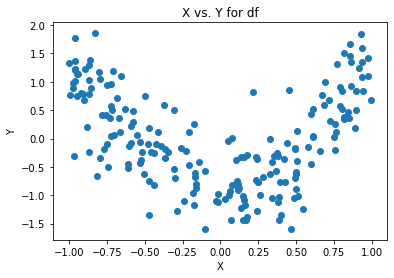

In [4]:
plt.scatter(df.x, df.y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("X vs. Y for df")

# STEP 2: Generate Polynomial Design Matrix of order 3
Assume we dont know that our data is best fit with a quadratic model and we will try regularization on higher order models to find the right model

In [5]:
modelOrder = 3


polynomialX = PolynomialFeatures(modelOrder)
polyX = polynomialX.fit_transform(df['x'].to_numpy().reshape(-1,1))

print( polynomialX.get_feature_names())
print(polyX.shape)

['1', 'x0', 'x0^2', 'x0^3']
(200, 4)


# STEP 3: Plot the values of the design matrix as a function of x

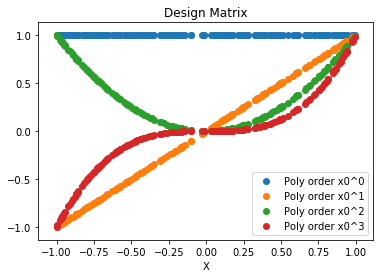

In [6]:
for cur_order in range(0,modelOrder+1):
    linelabel= "Poly order x0^" + str(cur_order)
    plt.scatter(df['x'],polyX[:,cur_order],label=linelabel)
    plt.title("Design Matrix")
    plt.xlabel("X")
    plt.legend()

# STEP 4: Create train and validations sets

In [7]:

trainX, valX, trainy, valy = train_test_split(polyX, df['y'], test_size=0.5, random_state=42)

# STEP 5: Create Grid of Alphas 

In [8]:
minalpha = -10
maxalpha = 10
alphagrid = np.logspace(minalpha,maxalpha,num=50)

# STEP 6: Create ridge regression model and display coefficients

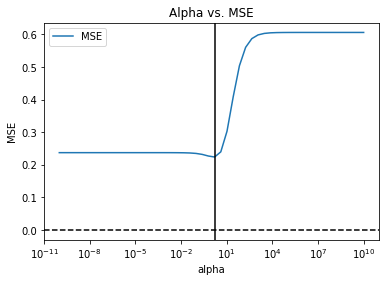

In [9]:
# ridgeCoeffs = np.zeros((len(alphagrid),modelOrder+1))
ridgeCoeffs = np.zeros((len(alphagrid),modelOrder+1))
ridgeMSEs = np.zeros(len(alphagrid))
ridgePreds = np.zeros((len(valX),len(alphagrid)))


i = 0
for i, myalpha in enumerate(alphagrid):
#     mymodelR = linear_model.Ridge(alpha = myalpha, fit_intercept=False)
    mymodelR = linear_model.Ridge(alpha = myalpha, fit_intercept=True)
    mymodelR.fit(trainX,trainy)
    preds = mymodelR.predict(valX)
    ridgePreds[:,i]=preds
    ridgeMSEs[i] = mean_squared_error(preds,valy)
    ridgeCoeffs[i,:] = mymodelR.coef_
    

    
minRidgeMSEindeces = np.argmin(ridgeMSEs)
minRidgeMSE = ridgeMSEs[minRidgeMSEindeces]
minRidgeAlpha = alphagrid[minRidgeMSEindeces]
    
    

plt.figure()
plt.semilogx(alphagrid,ridgeMSEs)
plt.legend(["MSE"])
plt.title("Alpha vs. MSE")
plt.axhline(linestyle = '--', color='k')
plt.axvline(x=minRidgeAlpha, color='k')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.show()



# STEP 7:  Plot coefficencts of ridge model as function of alphas

Best MSE Ridge coeffs:  [ 0.         -0.42601286  1.87516721  0.58605084]


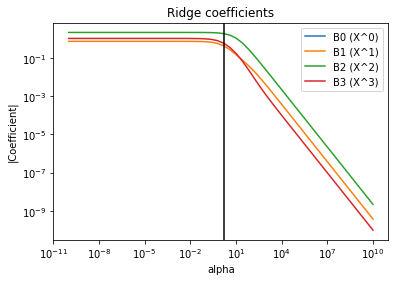

In [10]:
minRidgeMSEindex = np.argmin(ridgeMSEs)
minRidgeMSE = ridgeMSEs[minRidgeMSEindex]
minRidgeAlpha = alphagrid[minRidgeMSEindex]

print("Best MSE Ridge coeffs: ", ridgeCoeffs[minRidgeMSEindex,:])

plt.figure()
# plt.semilogx(alphagrid,ridgeCoeffs[:,0:modelOrder+1])
plt.loglog(alphagrid,np.abs(ridgeCoeffs[:,0:modelOrder+1]))
plt.legend(["B0 (X^0)","B1 (X^1)","B2 (X^2)","B3 (X^3)"])
plt.title("Ridge coefficients")
plt.axhline(linestyle = '--', color='k')
plt.axvline(x=minRidgeAlpha, color='k')
plt.xlabel('alpha')
plt.ylabel('|Coefficient|')
plt.show()

# STEP 8:  For Ridge, plot alphs vs. MSE on predictions of the validation set

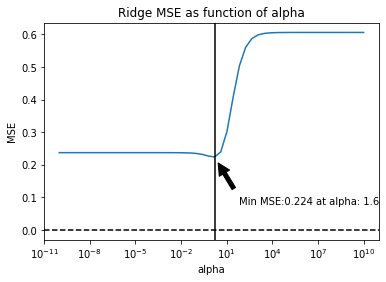

In [11]:
plt.figure()
# plt.semilogx(alphagrid,ridgeMSEs[:])
plt.semilogx(alphagrid,ridgeMSEs[:])
#plt.legend(["MSE"])
plt.title("Ridge MSE as function of alpha")
plt.annotate('Min MSE:'+ str(minRidgeMSE.round(3)) + ' at alpha: '+ str(minRidgeAlpha.round(3)) ,
            xy=(minRidgeAlpha, minRidgeMSE), xycoords='data',
            xytext=(1.00, 0.2), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.15),
            horizontalalignment='right', verticalalignment='top')
plt.axhline(linestyle = '--', color='k')
plt.axvline(x=minRidgeAlpha, color='k')

plt.xlabel('alpha')
plt.ylabel('MSE')
plt.show()

# STEP 9: Create LASSO regression model and display coefficients

In [12]:
lassoCoeffs = np.zeros((len(alphagrid),modelOrder+1))
lassoMSEs = np.zeros(len(alphagrid))
lassoPreds = np.zeros((len(valX),len(alphagrid)))

i = 0
for i, myalpha in enumerate(alphagrid):
    mymodelL = linear_model.Lasso(alpha = myalpha, fit_intercept=True)
    mymodelL.fit(trainX,trainy)
    preds = mymodelL.predict(valX)
    lassoPreds[:,i]=preds
    lassoMSEs[i] = mean_squared_error(preds,valy)
    lassoCoeffs[i,:] = mymodelL.coef_

# STEP 10:  Plot coefficients of LASSO as a function of alpha value & describe coefficients behavior

20
Best MSE LASSO coeffs:  [ 0.         -0.16077764  2.03756283  0.21327705]


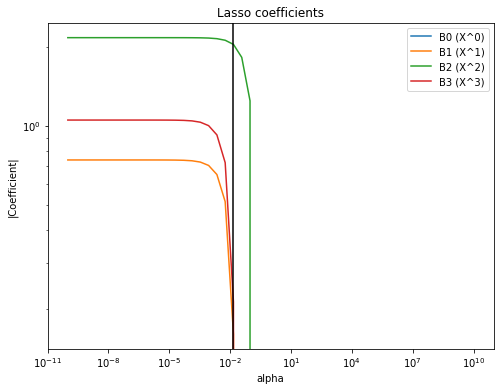

In [13]:
minlassoMSEindex = np.argmin(lassoMSEs)
minlassoMSE = lassoMSEs[minlassoMSEindex]
minlassoAlpha = alphagrid[minlassoMSEindex]

print(minlassoMSEindex)

print("Best MSE LASSO coeffs: ", lassoCoeffs[minlassoMSEindex,:])

plt.figure(figsize=(8, 6))
# plt.semilogx(alphagrid,lassoCoeffs[:,0:modelOrder+1])
plt.loglog(alphagrid,np.abs(lassoCoeffs[:,0:modelOrder+1]))
plt.legend(["B0 (X^0)","B1 (X^1)","B2 (X^2)","B3 (X^3)"])
plt.title("Lasso coefficients")
plt.axhline(linestyle = '--', color='k')
plt.axvline(x=minlassoAlpha, color='k')
plt.xlabel('alpha')
plt.ylabel('|Coefficient|')
plt.show()

# STEP 11:  For LASSO, plot alphas vs. MSE on predictions of the validation set

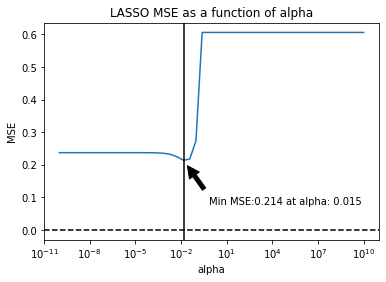

In [14]:
plt.figure()
plt.semilogx(alphagrid,lassoMSEs[:])
#plt.legend(["MSE"])
plt.title("LASSO MSE as a function of alpha")
plt.annotate('Min MSE:'+ str(minlassoMSE.round(3)) + ' at alpha: '+ str(minlassoAlpha.round(3)) ,
            xy=(minlassoAlpha, minlassoMSE), xycoords='data',
            xytext=(0.95, 0.2), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.15),
            horizontalalignment='right', verticalalignment='top')
plt.axhline(linestyle = '--', color='k')
plt.axvline(x=minlassoAlpha, color='k')

plt.xlabel('alpha')
plt.ylabel('MSE')
plt.show()

# STEP 12:  Use validation set to determine best ridge and lasso values for data and plot the truth and predictions from both models on the val set

Ridge  best model - at alpha  1.5998587196060574  MSE =  0.22402910706569037
LASSO  best model - at alpha  0.014563484775012445  MSE =  0.2139834226811681
LASSO Model is the best model 


Text(0.5, 1.0, 'Validation Model Predictions')

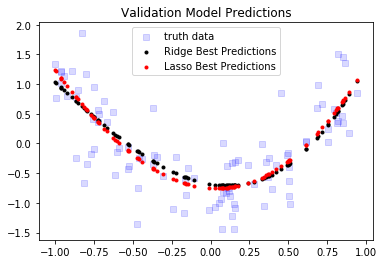

In [15]:
print("Ridge  best model - at alpha ", minRidgeAlpha, " MSE = ", minRidgeMSE)
print("LASSO  best model - at alpha ", minlassoAlpha, " MSE = ", minlassoMSE)


if minRidgeMSE < minlassoMSE:
    print("Ridge Model is the best model" )
else:
    print("LASSO Model is the best model ")
    
plt.scatter(valX[:,1],valy,marker=',',color='b',alpha=0.15,label="truth data")
plt.scatter(valX[:,1],ridgePreds[:,minRidgeMSEindex],marker='.', color='k',alpha=1.0,label="Ridge Best Predictions")
plt.scatter(valX[:,1],lassoPreds[:,minlassoMSEindex],marker='.', color='r',alpha=1.0,label="Lasso Best Predictions")
plt.legend()
plt.title("Validation Model Predictions")